<a href="https://colab.research.google.com/github/rafaelnduarte/RFM_Customer_Segmentation/blob/master/RFM_Customer_Segmentation_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation

[![LinkedIn](https://img.shields.io/badge/LinkedIn-rafaelnduarte-blue.svg)](https://www.linkedin.com/in/rafael-n-duarte)
[![GitHub](https://img.shields.io/badge/GitHub-rafaelnduarte-purple.svg)](https://github.com/rafaelnduarte)

This is one of the three notebooks on my Customer Segmentation project. To understand the process of acquiring and cleaning the data, please, visit the **Time Series** part of the project. 

Make sure you check out the other parts:
>* [Forecasting Sales with Prophet]('')
* [Understanding Your Customers With NLP]('')

For our Customer Segmentation, we'll be doing a **RFM** analysis.

According to [clevertap.com](https://clevertap.com/blog/rfm-analysis/) RFM stands for **Recency**, **Frequency**, and **Monetary** value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.

<center><img width="90%" src="https://d35fo82fjcw0y8.cloudfront.net/2018/03/01013508/Incontent_image.png"></center>

### Why is it important? What can we get from it?

* Who are your best customers?
* Which of your customers could contribute to your churn rate?
* Who has the potential to become valuable customers?
* Which of your customers can be retained?
* Which of your customers are most likely to respond to engagement campaigns?

These are key questions that we can answer with this analysis. Let's get it going.

In [7]:
#@title Importing Packages
# importing the necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
import datetime as dt
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt
import scipy.stats as scs

import warnings
warnings.filterwarnings("ignore")
sns.set_style()
%matplotlib inline

# Import statements required for Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [3]:
# importing the data
path = ('https://www.dropbox.com/s/gotbas8az85ewg4/df_clean.csv?dl=1')
df_clean = pd.read_csv(path, encoding='latin-1')

df_clean.index = pd.to_datetime(df_clean['InvoiceDate'], infer_datetime_format=True)

df_clean.drop('InvoiceDate', axis=1, inplace=True)


df_clean.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,AmountSpent,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,Weekend
InvoiceDate,,,,,,,,,,,,,,,,,,
2010-12-01 08:26:00,0,536365,85123A,white hanging heart t-light holder,6,2.55,17850,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01,0
2010-12-01 08:26:00,1,536365,71053,white metal lantern,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0
2010-12-01 08:26:00,2,536365,84406B,cream cupid hearts coat hanger,8,2.75,17850,United Kingdom,22.00,2010,4,12,48,2,1,335,2010-12-01,0
2010-12-01 08:26:00,3,536365,84029G,knitted union flag hot water bottle,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0
2010-12-01 08:26:00,4,536365,84029E,red woolly hottie white heart.,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0


## Recency

First, let's understand our data, and see what the last day of the dataset is. This is important for us to calculate the metrics we need for our RFM Analysis.

In [4]:
# last date available in our dataset
df_clean.index.max()

Timestamp('2011-12-09 12:50:00')

In [0]:
# setting now to calculate time differences
now = dt.date(2011,12,9)

In [9]:
# group by customer by last date they purchased

recency_df = df_clean.groupby(['CustomerID'],as_index=False)['Date'].max()
recency_df.columns = ['CustomerID','LastPurchaseDate']
recency_df['LastPurchaseDate'] = pd.DatetimeIndex(recency_df.LastPurchaseDate).date
recency_df.head()

,CustomerID,LastPurchaseDate
0,12346,2011-01-18
1,12347,2011-12-07
2,12348,2011-09-25
3,12349,2011-11-21
4,12350,2011-02-02


In [10]:
# calculate how often the customers are buying in the last few days

recency_df['Recency'] = recency_df.LastPurchaseDate.apply(lambda x : (now - x).days)

# dropping LastPurchase Date
recency_df.drop(columns=['LastPurchaseDate'],inplace=True)

# checking recency
recency_df.head()

,CustomerID,Recency
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310


Great! We now have the tima in days since the last purchase made by our customers.

## Frequency

Frequency is caculated by how many purchases a cosumer made over time.

Let's see what it looks like in our data.

In [11]:
# calculating frequency
frequency_df = df_clean.copy()
frequency_df.drop_duplicates(subset=['CustomerID','InvoiceNo'], keep="first", inplace=True) 
frequency_df = frequency_df.groupby('CustomerID',as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1


## Monetary

The last aspect to be analyzed is the Monetary part. That is, how much money is being spent by the customers.

In [12]:
# check summed up spend of customers

monetary_df=df_clean.groupby('CustomerID',as_index=False)['AmountSpent'].sum()
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


In [13]:
# putting recency and frequency together
rf = recency_df.merge(frequency_df,left_on='CustomerID',right_on='CustomerID')

# combining with monetary values
rfm = rf.merge(monetary_df,left_on='CustomerID',right_on='CustomerID')

rfm.set_index('CustomerID',inplace=True)

# saving to file
rfm.to_csv('rfm.csv', index=False)

# checking the dataframe
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,18,1,1757.55
12350,310,1,334.40


## Segmentation and Evaluation

To do proper segmentation of our clients, we're going to use **K-Means Clustering** to create clusters of clients, which we'll name:

* **Gold** - Frequent and and generate high volume of revenue.
* **Silver** - Frequent but generates less revenue.
* **Bronze** - Less frequent, low revenue.

In [0]:
# importing kmeans
from sklearn.cluster import KMeans

# creating a copy of the dataframe
rfm_segmentation = rfm.copy()

#### Elbow Method
For K-Means, we have to set a number of clusters for our data to be divided in. Since this is, at first, a completely arbitrary task, we have to look for options to make it as precise as possible.

One of the most popular methods to do so is the **Elbow Method**. Basically, we calculate different scenarios for different numbers of clusters and then plot them in a line. 

> The number we're looking for is the position where the line starts to flatten, making it look like an elbow for the plot. After some testing, I've figured out that 3 clusters yield better results.

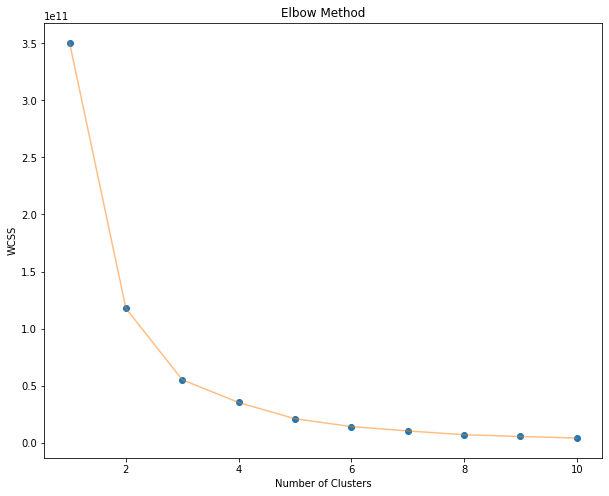

In [16]:
# finding out the proper number of clusters
fig,ax = plt.subplots(figsize=(10,8))
wcss = []
for i in range(1,11):
  kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
  kmeans.fit(rfm_segmentation)
  wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss, 'o')
plt.plot(range(1 , 11) , wcss , '-' , alpha = 0.5)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.savefig('Elbow_Method.png')
plt.show()

In [0]:
# instantiating the model
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(rfm_segmentation)

With our data separated, it's important to know the customers in each cluster.

To do that, let's create a new column, assigning the cluster to the customer.

In [0]:
# creating a column for the cluster
rfm_segmentation['Cluster'] = kmeans.labels_

In [19]:
# checking the column
rfm_segmentation[rfm_segmentation.Cluster == 0].head(10)

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12347,2,7,4310.00,0
12348,75,4,1797.24,0
12349,18,1,1757.55,0
12350,310,1,334.40,0
12352,36,8,2506.04,0
12353,204,1,89.00,0
12354,232,1,1079.40,0
12355,214,1,459.40,0
12356,22,3,2811.43,0


Great! Now let's analyze Recency, Frequency and Monetary values for each Cluster. 

Let's start with Recency.

### Recency
* Cluster 0 has **high recency rate**, which means it's been the longest for any cluster when it comes to Last Purchase Date.
* CLuster 1 and 2 have **low recency rate**, which is good. They can be our Gold and Silver Customers.

Let's dive deeper.

ERROR! Session/line number was not unique in database. History logging moved to new session 61


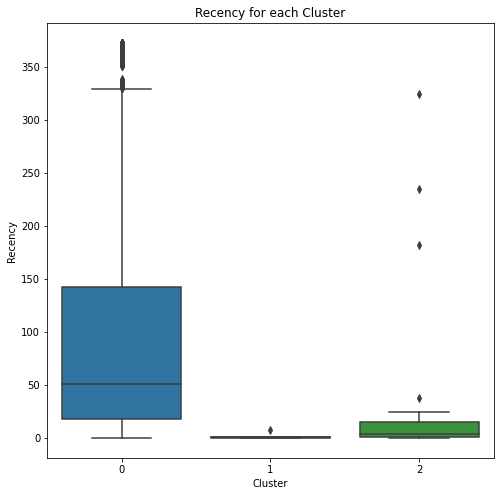

In [20]:
# analyzing Recency
fig, ax = plt.subplots(figsize=(8,8))
plt.title('Recency for each Cluster')
sns.boxplot(rfm_segmentation.Cluster,rfm_segmentation.Recency);

### Frequency

* Cluster 0 has a **low frequency rate**, which means consumers in this cluster are not very frequent.
* Clusters 1 and 2 have **high frequency rates**, which puts them even further in the race for Gold.

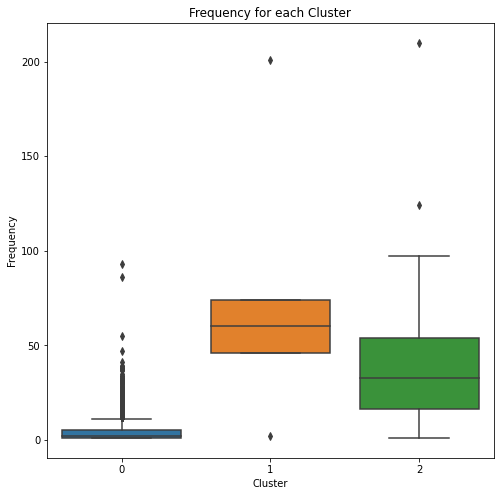

In [21]:
# analyzing frequency rate
fig, ax = plt.subplots(figsize=(8,8))
plt.title('Frequency for each Cluster')
sns.boxplot(rfm_segmentation.Cluster,rfm_segmentation.Frequency);

### Monetary

* Cluster 0 has a **monetary rate**, so that makes it shows that Cluster 0 is where our **Bronze** Customers are.
* Cluster 2 has a **medium level** monetary rate, which makes it the Cluster for our **Silver** Customers.
* Cluster 1 has **the highest monetary rate**, making it the Cluster for our **Gold** Customers.

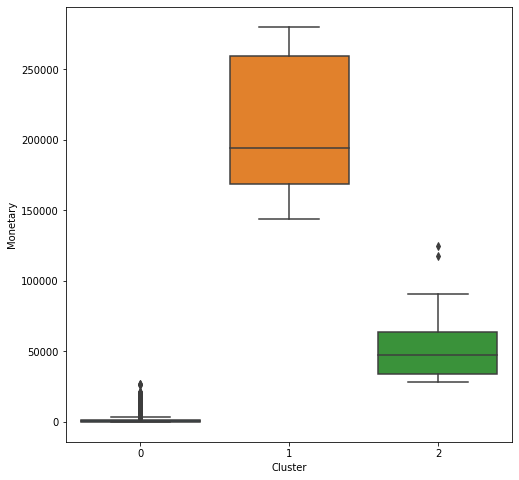

In [22]:
# anaulyzing monetary rates
fig, ax = plt.subplots(figsize=(8,8))
sns.boxplot(rfm_segmentation.Cluster,rfm_segmentation.Monetary);

### Conclusions
As seen before, we have found that:
<center><img width="50%" src="https://drive.google.com/uc?id=14Ds-I9efhNes8m4rDeKVB4m_DygzMEpD"></center>

* **Gold** Customers are in Cluster 1
* **Silver** Customers are in Cluster 2
* **Bronze** Customers are in Cluster 0


### Further Analysis
Of course, we can take a deeper look and identify other patterns and kinds of customers.

For that, we need to do an even better job when it comes to assigning "grades" to the customers.

To do that, let's create some other features.

In [0]:
# arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)

# lower the recency, good for the company
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
    
# arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)

# higher value of frequency and monetary lead to a good consumer. Here higher value = 1 in reverse way.

def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

A quantile is each of any set of values of a variate which divide a frequency distribution into equal groups, each containing the same fraction of the total population.

In [24]:
# finding significant quantiles for each variable
quantile = rfm.quantile(q=[0.25,0.5,0.75])
quantile

,Recency,Frequency,Monetary
0.25,17.0,1.0,307.245
0.50,50.0,2.0,674.450
0.75,141.5,5.0,1661.640


In [0]:
# identifying quantiles
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore,args=('Recency',quantile))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantile))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantile))

In [26]:
# calculating RFM score
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
# checking the dataframe
rfm_segmentation.head()

,Recency,Frequency,Monetary,Cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
12346,325,1,77183.60,2,4,4,1,441
12347,2,7,4310.00,0,1,1,1,111
12348,75,4,1797.24,0,3,2,1,321
12349,18,1,1757.55,0,2,4,1,241
12350,310,1,334.40,0,4,4,3,443


There is one more metric we can use, which is summing up the scores, instead of just putting them together.

The advantage of this method is that each of the scores has the same level of importance. However, it may be less revealing, and leaves more room for uncertainty.

For example, a consumer with value 413 and 431 would score the same on this scale, but maybe, for the company, Frequency is more important than Monetary rate, and for them, these two don't have the same value.

That's why it's important to keep both metrics.

In [27]:
# creating total score
rfm_segmentation['TotalScore'] = rfm_segmentation['R_Quartile'] + rfm_segmentation['F_Quartile'] + \
rfm_segmentation['M_Quartile']

rfm_segmentation.head()

,Recency,Frequency,Monetary,Cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore,TotalScore
CustomerID,,,,,,,,,
12346,325,1,77183.60,2,4,4,1,441,9
12347,2,7,4310.00,0,1,1,1,111,3
12348,75,4,1797.24,0,3,2,1,321,6
12349,18,1,1757.55,0,2,4,1,241,7
12350,310,1,334.40,0,4,4,3,443,11


In [28]:
# printing results
best = len(rfm_segmentation[rfm_segmentation['RFMScore']=='111'])
loyal = len(rfm_segmentation[rfm_segmentation['F_Quartile']==1])
big_spenders = len(rfm_segmentation[rfm_segmentation['M_Quartile']==1])
almost_lost = len(rfm_segmentation[rfm_segmentation['RFMScore']=='134'])
lost_cust = len(rfm_segmentation[rfm_segmentation['RFMScore']=='344'])
lost_cheap = len(rfm_segmentation[rfm_segmentation['RFMScore']=='444'])


print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==1]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==1]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='134']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='344']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))

Best Customers:  456
Loyal Customers:  872
Big Spenders:  1085
Almost Lost:  34
Lost Customers:  208
Lost Cheap Customers:  443


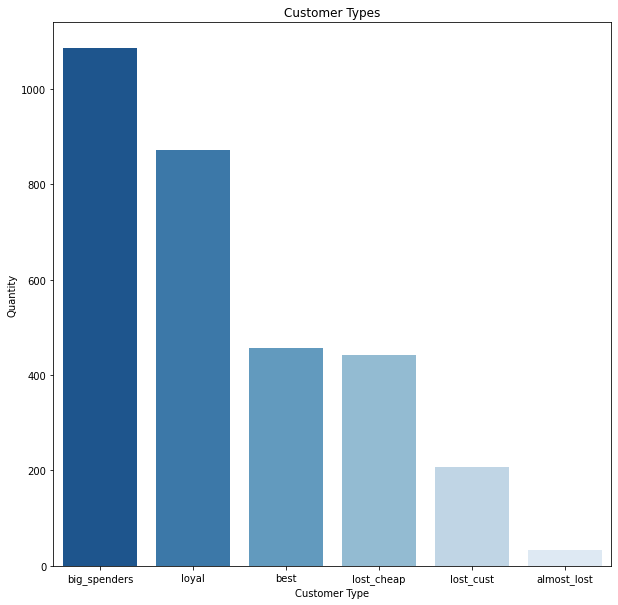

In [31]:
# visualizing the customers
cust = pd.DataFrame([[best,loyal,big_spenders,almost_lost,lost_cust,lost_cheap]],columns=['best','loyal','big_spenders','almost_lost','lost_cust','lost_cheap'])
fig, ax = plt.subplots(figsize=(10,10))
cust_melt = pd.melt(cust)
sns.barplot(x = cust_melt.variable, y = cust_melt.value, order=['big_spenders', 'loyal', 'best', 'lost_cheap','lost_cust', 'almost_lost'], palette="Blues_r");
plt.title('Customer Types')
plt.ylabel('Quantity')
plt.xlabel('Customer Type');

### Understanding each metric a little better
Let's take a closer look at each of our parameters and see what more they can tell us about our data.

In [32]:
# analyzing monetary
rfm_segmentation.sort_values(by=['RFMScore', 'Monetary'], ascending=[True, False])

,Recency,Frequency,Monetary,Cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore,TotalScore
CustomerID,,,,,,,,,
14646,1,74,280206.02,1,1,1,1,111,3
18102,0,60,259657.30,1,1,1,1,111,3
17450,8,46,194550.79,1,1,1,1,111,3
14911,1,201,143825.06,1,1,1,1,111,3
14156,9,55,117379.63,2,1,1,1,111,3
...,...,...,...,...,...,...,...,...,...
17102,261,1,25.50,0,4,4,4,444,12
15823,372,1,15.00,0,4,4,4,444,12
17763,263,1,15.00,0,4,4,4,444,12


In [33]:
# analyzing monetary
rfm_segmentation.groupby('RFMScore')['Monetary'].mean()

RFMScore
111    9547.540000
112    1286.331270
113     511.270000
114     253.920000
121    2910.558864
          ...     
434     214.629524
441    8910.267273
442     994.800000
443     414.643767
444     164.885056
Name: Monetary, Length: 61, dtype: float64

When analyzing Recency, we can understand Total Scores of 10, 11 and 12 as the highest. These can be a combination o 444, 434, 334, etc.

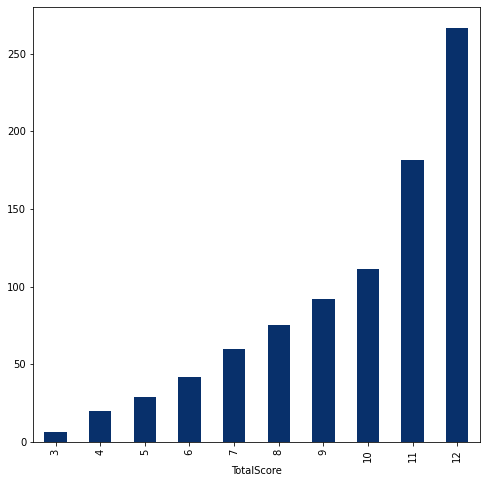

In [35]:
# analyzing Recency
fig, ax = plt.subplots(figsize=(8,8))
rfm_segmentation.groupby('TotalScore')['Recency'].mean().plot(kind='bar', colormap='Blues_r');

When it comes to Frequency, the highest values are 3, 4 and 5. These can be a combination of 111, 121, 122, etc.

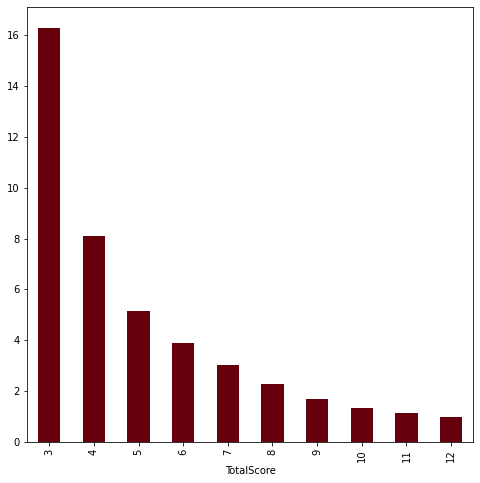

In [36]:
# analyzing Frequency
fig, ax = plt.subplots(figsize=(8,8))
rfm_segmentation.groupby('TotalScore')['Frequency'].mean().plot(kind='bar', colormap='Reds_r');

And, finally, analyzing Monetary rates, 3, 4 and 5 have the highest value, being a possible combination of 111, 121, 122, etc.

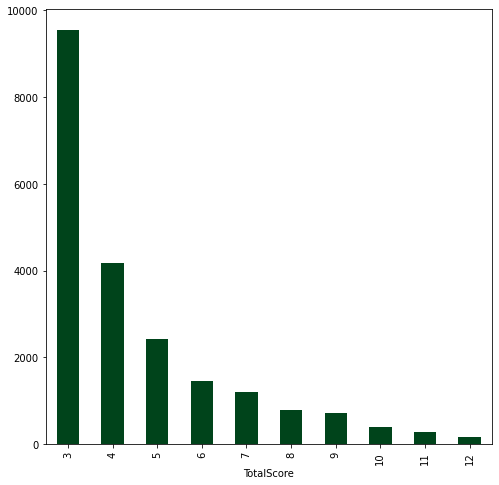

In [37]:
# analyzing Monetary
fig, ax = plt.subplots(figsize=(8,8))
rfm_segmentation.groupby('TotalScore')['Monetary'].mean().plot(kind='bar', colormap='Greens_r');

### Visualizing the Clusters

Just to wrap it up, let's take a look at these clusters.

In [0]:
# getting the values
X = rfm_segmentation.iloc[:, [0,1,2]].values

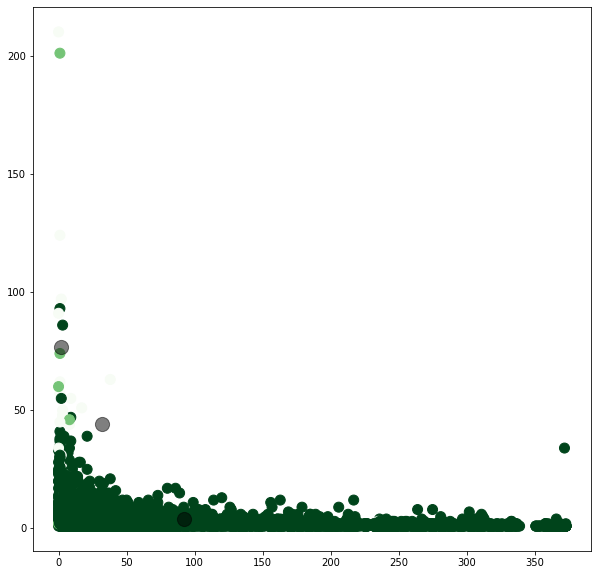

In [39]:
# 2d plot
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=100, cmap='Greens_r')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [40]:
# checking number of clients per cluster
rfm_segmentation.Cluster.value_counts()

0    4304
2      30
1       5
Name: Cluster, dtype: int64

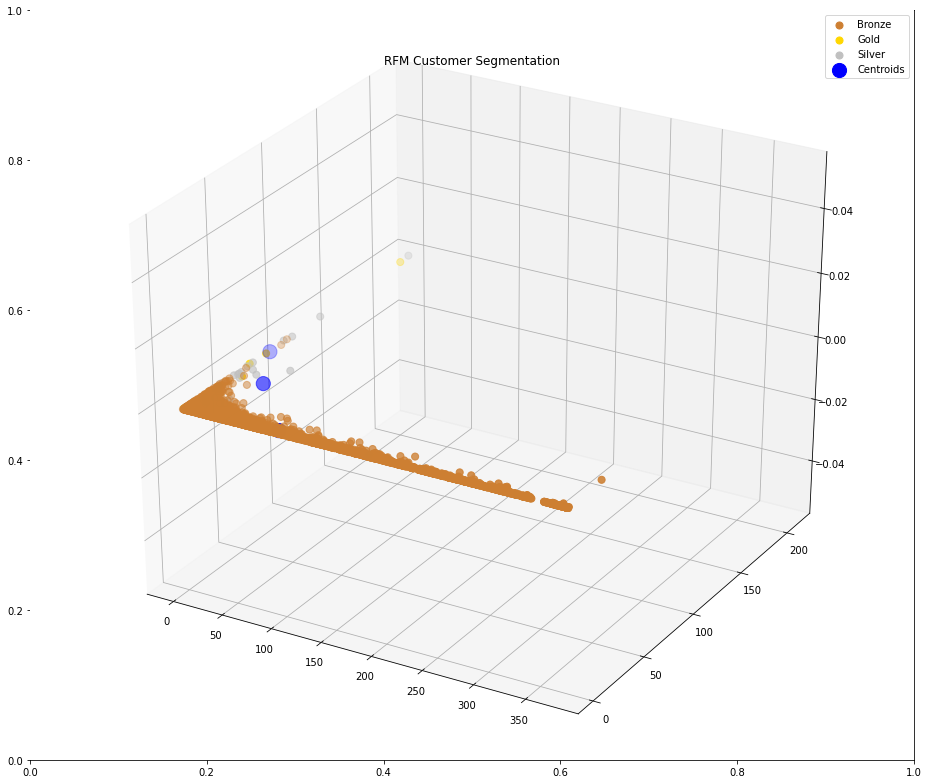

In [43]:
from mpl_toolkits.mplot3d import Axes3D
# 3D visualization
# visualizing clusters
fig, ax = plt.subplots(figsize=(13,11))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(X[y_kmeans == 0,0],X[y_kmeans == 0,1], s= 50, c= '#cd7f32',label= 'Bronze')
plt.scatter(X[y_kmeans == 1,0], X[y_kmeans == 1,1], s= 50, c= 'gold', label= 'Gold')
plt.scatter(X[y_kmeans == 2,0], X[y_kmeans == 2,1], s= 50, c= 'silver', label= 'Silver')
# centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s= 200, c= 'Blue', label= 'Centroids')
plt.title('RFM Customer Segmentation')
plt.legend()
# plt.savefig('clusters.png')
plt.tight_layout()

In [0]:
import chart_studio as py
import plotly.express as px
import plotly.graph_objects as go

In [58]:
# 3D interactive plot
scatter = dict(
    mode = "markers",
    name = "y",
    type = "scatter3d",
    x = rfm_segmentation['Recency'], y = rfm_segmentation['Frequency'], z = rfm_segmentation['Monetary'],
    marker = dict( size=2, color="rgb(23, 190, 207)" )
)
clusters = dict(
    alphahull = 3,
    name = "y",
    opacity = 0.1,
    type = "mesh3d",
     x = rfm_segmentation['Recency'], y = rfm_segmentation['Frequency'], z = rfm_segmentation['Monetary']
)
layout = dict(
    title = '3d point clustering',
    scene = dict(
        xaxis = dict( zeroline=False ),
        yaxis = dict( zeroline=False ),
        zaxis = dict( zeroline=False ),
    )
)
#fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
fig = go.Figure( data=[scatter, clusters], layout=layout )
fig.show()


The distribution of our data doesn't really help our visualization, but with Plotly's interactive graph it's a lot easier to understand what we're dealing with.

# Thank You!

Thank you for your time and attention. I hope this was an informative and interesting project. Should you have any questions or any kind of feedback, feel free to contact me on [LinkedIn](https://www.linkedin.com/in/rafael-n-duarte/), and check out my other projects on [GitHub](https://github.com/rafaelnduarte/portfolio).


[![LinkedIn](https://img.shields.io/badge/LinkedIn-rafaelnduarte-blue.svg)](https://www.linkedin.com/in/rafael-n-duarte)
[![GitHub](https://img.shields.io/badge/GitHub-rafaelnduarte-purple.svg)](https://github.com/rafaelnduarte)

<center><img width="90%" src="https://github.com/rafaelnduarte/Portfolio/blob/master/rafaelnd_banner.png?raw=true"></center>